In [382]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces


In [383]:
GRID_SIZE = 10

In [384]:
class GridEnv(gym.Env):
    def __init__(self):
        super(GridEnv, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=0, high=GRID_SIZE-1, shape=(2,), dtype=np.int32)
        self.reward_map = None
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((GRID_SIZE, GRID_SIZE), -1)
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        self.reward_map[GRID_SIZE-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100

    def step(self, action):
        # Initialize done as False
        done = False
        reward = 0.
        # Action mappings (no changes here)
        action_mappings = {
            0: (-1, 0),  # Move up
            1: (1, 0),   # Move down
            2: (0, -1),  # Move left
            3: (0, 1)    # Move right
        }
        
        # Update state based on action with x, y format
        delta = action_mappings.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])

        # Check and handle boundary conditions
        if new_state[1] < 0 or new_state[1] >= GRID_SIZE or new_state[0] < 0 or new_state[0] >= GRID_SIZE:
            # print(f"Out of bounds in [{new_state[0]}, {new_state[1]}]")
            reward = -100
            done = True
        else:
            self.state = new_state
            self.step_counter += 1
            reward = self.calculate_reward()
            done = self.is_done()

        y = self.state[0]
        x = self.state[1]

        # Check if goal is reached and update the reward map
        if y == GRID_SIZE - 1 and x == 0 and self.total_rewards_collected == 0: 
            print("Goal 1 reached")
            self.total_rewards_collected += 1
            self.reward_map[GRID_SIZE-1, 1] = 100  # Set new goal
            self.reward_map[y, x] = -1  # Update old goal position
        if y == GRID_SIZE - 1 and x == 1 and self.total_rewards_collected == 1: 
            print("Goal 2 reached")
            self.total_rewards_collected += 1
            self.reward_map[GRID_SIZE-2, 1] = 100  # Set new goal
            self.reward_map[y, x] = -1  # Update old goal position
        if y == GRID_SIZE - 2 and x == 1 and self.total_rewards_collected == 2: 
            print("Goal 3 reached")
            self.total_rewards_collected += 1
            self.reward_map[GRID_SIZE-3, 1] = 100  # Set new goal
            self.reward_map[y, x] = -1  # Update old goal position
        if y == GRID_SIZE - 3 and x == 1 and self.total_rewards_collected == 3: 
            print("Goal 3 reached")
            self.total_rewards_collected += 1
            self.reward_map[GRID_SIZE-4, 1] = 100  # Set new goal
            self.reward_map[y, x] = -1  # Update old goal position
        
        return self.state, reward, done, {}

        
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        # if self.state[0] == self.grid_size - 1:
        #     return 100
        # print(f"Reward obtained: {self.reward_map[self.state[0], self.state[1]]}")
        return self.reward_map[self.state[0], self.state[1]]        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = 100  # Example step limit
        return np.all(self.reward_map == -1) or self.step_counter >= max_steps            
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [385]:
def train_agent(env, agent, episodes):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward # Performance

        if (episode % 10 == 0):
            print(f"Episode {episode}: Total Reward: {total_reward}")

In [386]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((GRID_SIZE, GRID_SIZE, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Random action
        else:
            state_index = (state[0], state[1])
            action = np.argmax(self.q_table[state_index])
        return action
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error

    def train(self, episodes):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state


In [387]:
# Train the agent
env = GridEnv()
agent = QLearningAgent(env)
train_agent(env, agent, episodes=1000)


Episode 0: Total Reward: -100
Episode 10: Total Reward: -130
Goal 1 reached
Episode 20: Total Reward: -100
Goal 1 reached
Episode 30: Total Reward: -42
Goal 1 reached
Episode 40: Total Reward: -27
Goal 1 reached
Episode 50: Total Reward: -171
Goal 1 reached
Goal 1 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Episode 60: Total Reward: 30
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Episode 70: Total Reward: 1
Goal 1 reached
Goal 1 reached
Goal 1 reached
Goal 1 reached
Goal 1 reached
Goal 1 reached
Episode 80: Total Reward: -14
Goal 1 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Episode 90

Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal 2 reached
Goal 1 reached
Episode 150: Total Reward: -101
Goal 1 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Episode 160: Total Reward: -100
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Goal 1 reached
Goal 2 reached
Goal 3 reached
Goal 3 reached
Episode 170: Total Reward: 2526
Goal 1 reached
Goal 2 reached
Goal 1 reached
Goal

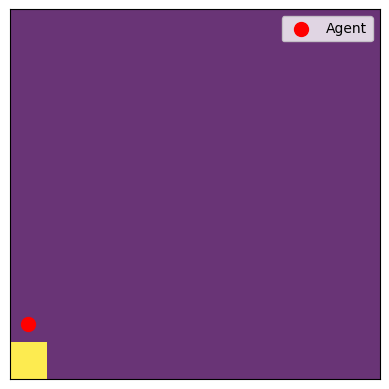

In [388]:
def animation_plot(env, ax):
    ax.clear()
    ax.imshow(env.reward_map, cmap='viridis', alpha=0.8)
    ax.scatter(env.state[1], env.state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

# print(env.reward_map)
def update(frame, env, agent, ax):
    if not hasattr(update, "done") or not update.done:
        action = agent.choose_action(env.state)
        _, _, update.done, _ = env.step(action)
        animation_plot(env, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
env.reset()

# Create the animation
animation = FuncAnimation(fig, lambda frame: update(frame, env, agent, ax), frames=100, interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


In [389]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)